# 다중선형회귀

## #01. 패키지 설치

In [2]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

## #02. 데이터 셋 준비

In [3]:
origin = read_excel("https://data.hossam.kr/F02/fish2.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

길이    0
높이    0
두께    0
무게    0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계확인

In [5]:
origin.describe()

,길이,높이,두께,무게
count,56.000000,56.000000,56.000000,56.000000
mean,27.892857,7.862143,4.745536,382.239286
std,9.021668,2.878343,1.775006,347.617717
min,8.400000,2.110000,1.410000,5.900000
25%,21.825000,5.690000,3.520000,120.000000
50%,25.300000,6.920000,4.155000,207.500000
75%,36.625000,10.850000,6.450000,692.500000
max,44.000000,12.800000,8.140000,1100.000000


### 상자그림

In [6]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.unicode_minus'] = False

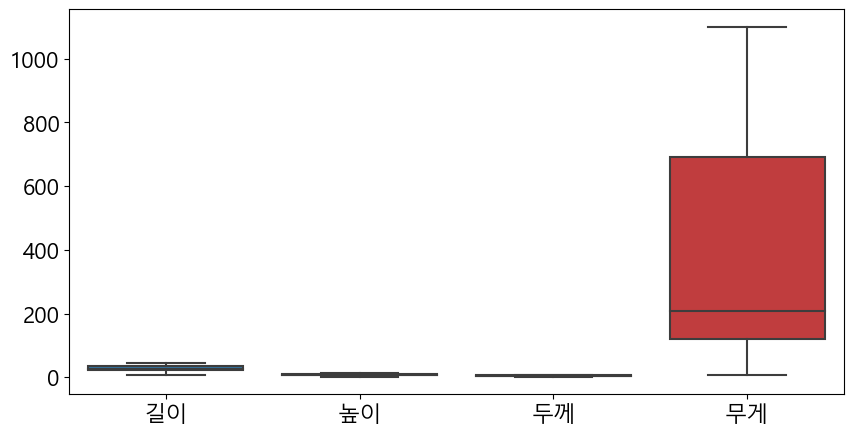

In [7]:
plt.figure(figsize=(10,5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터의 분포가 상이하므로 표준화가 필요해보인다.

### 산점도 그래프 확인

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

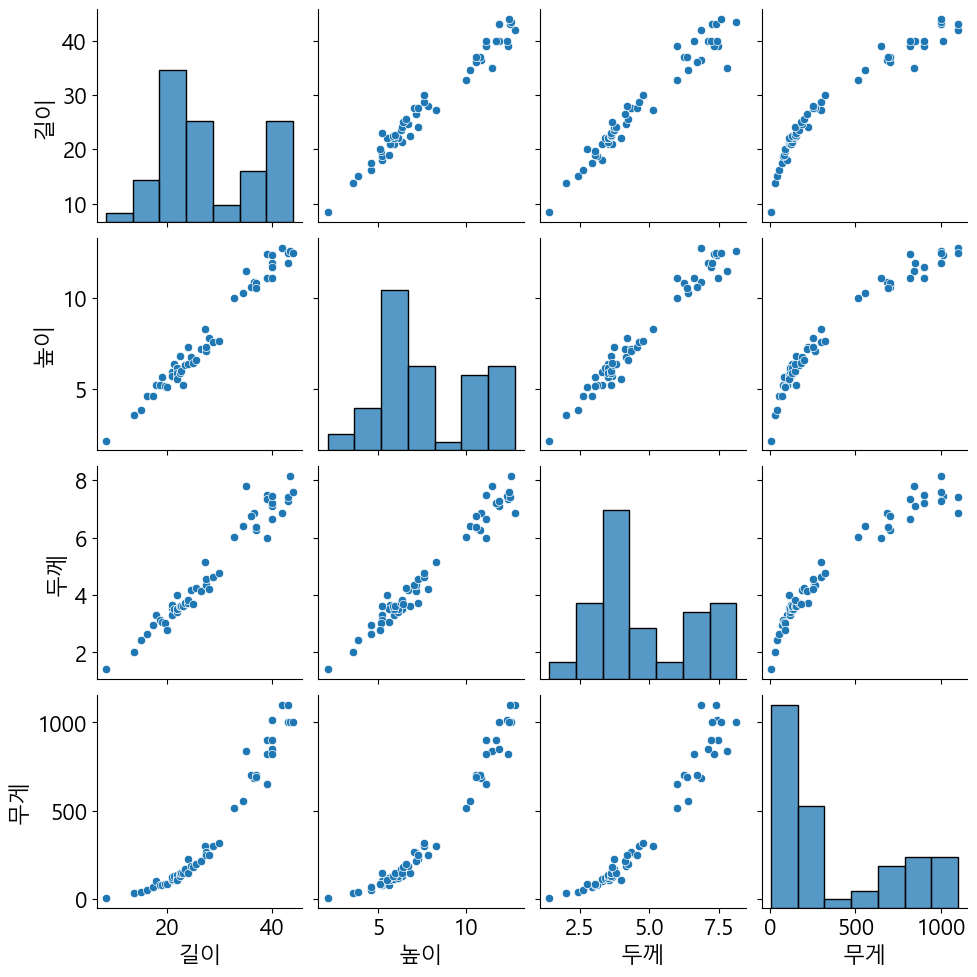

In [8]:
plt.figure(figsize=(30,30))
sb.pairplot(origin)
plt.show()
plt.close()

> 다중공선성이 발생할 것으로 보이고, 선형회귀보다는 다항회귀가 더 적합해보이지만 예제를 위해 다항선형회귀로 진행하기로 함.

## #05. 데이터 분리

### 랜덤시드 고정

In [9]:
np.random.seed(777)

### 훈련데이터(독립변수)와 레이블(종속변수) 구분하기

In [10]:
x = origin[['길이', '높이', '두께']]
y = origin[['무게']]
x.shape, y.shape

((56, 3), (56, 1))

### 데이터 표준화

In [11]:
# 훈련데이터(독립변수) 표준화
x_scaler = StandardScaler()
x_scale = x_scaler.fit_transform(x)

# 레이블(종속변수)표준화
y_scaler = StandardScaler()
y_scale = y_scaler.fit_transform(y)

x_scale.shape, y_scale.shape

((56, 3), (56, 1))

### 표준화 전 후 상자그림 비교

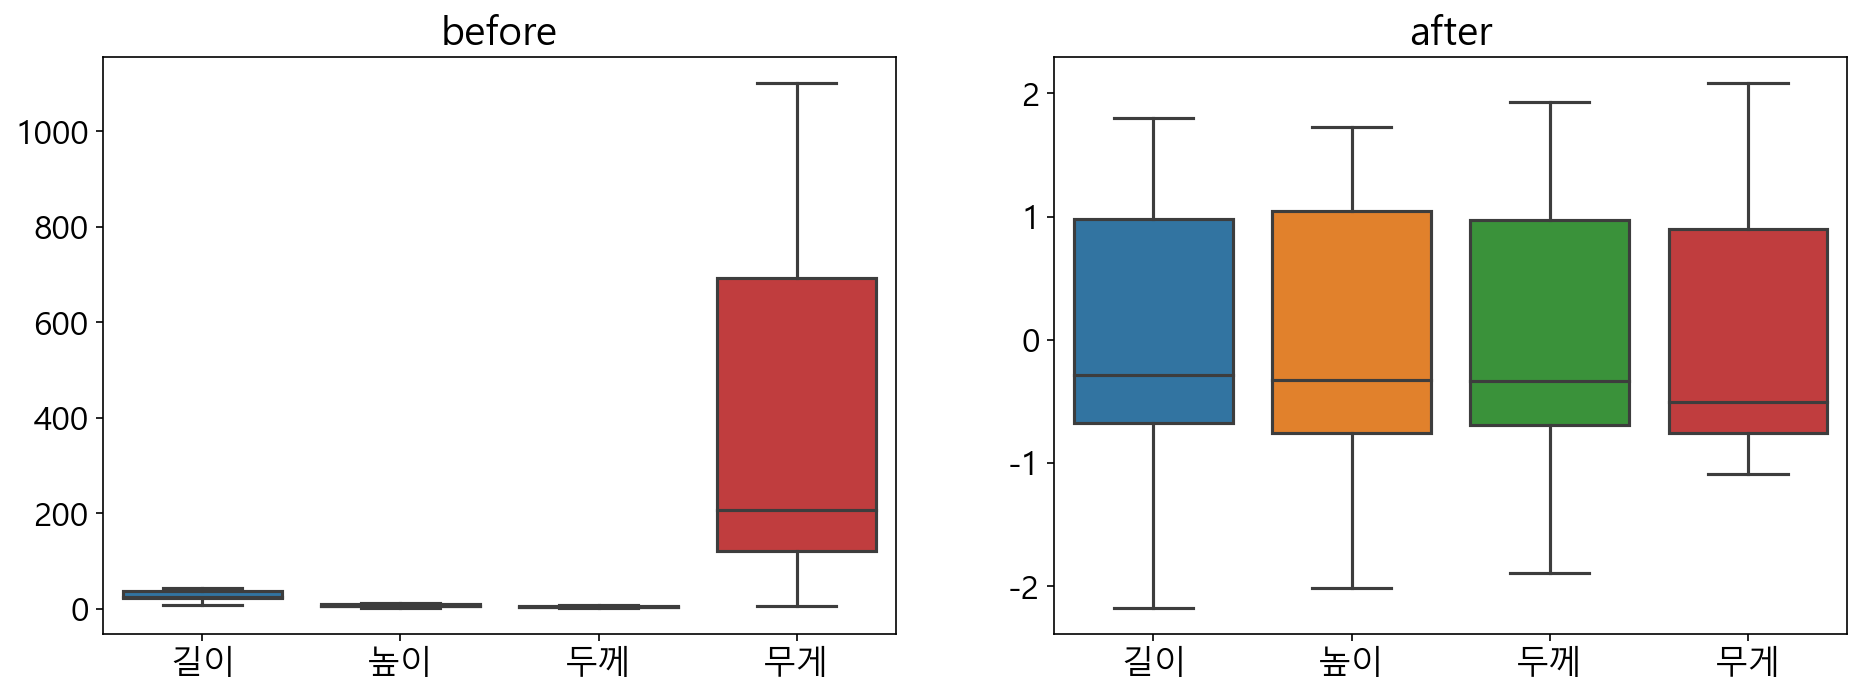

In [12]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['길이','높이','두께'])
y_scale_df = DataFrame(y_scale, columns=['무게'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True) 

fig, ax = plt.subplots(1,2,figsize=(15,5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련데이터와 검증데이터로 분할

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

## #06. 모델 생성

### 모델 정의

데이터가 단순하고 개수가 적다면 과적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.

In [17]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫번째 Dense 층
# input_shape = 독립변수의 갯수 (길이, 높이, 두께) = >3개
model.add(Dense(64, activation = 'relu', input_shape=(len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# 마지막 층
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [19]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
2/2 [==============================] - 1s 191ms/step - loss: 1.0626 - mae: 0.9417 - val_loss: 0.7367 - val_mae: 0.7860 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 32ms/step - loss: 0.8836 - mae: 0.8595 - val_loss: 0.6096 - val_mae: 0.7143 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 40ms/step - loss: 0.7361 - mae: 0.7812 - val_loss: 0.4959 - val_mae: 0.6430 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 57ms/step - loss: 0.5966 - mae: 0.7028 - val_loss: 0.3975 - val_mae: 0.5736 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 32ms/step - loss: 0.4779 - mae: 0.6298 - val_loss: 0.3126 - val_mae: 0.5058 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 32ms/step - loss: 0.3802 - mae: 0.5634 - val_loss: 0.2433 - val_mae: 0.4433 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 32ms/step - loss: 0.2943 - mae: 0.4991 - val_loss: 0.1898 - val_mae: 0.3931 - lr: 0.001

## #07. 학습모델 평가

In [20]:
# 학습결과 
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,1.062634,0.941655,0.736695,0.786002,0.001
2,0.883598,0.859466,0.609576,0.714326,0.001
3,0.736140,0.781177,0.495896,0.643035,0.001
4,0.596555,0.702779,0.397473,0.573606,0.001
5,0.477904,0.629827,0.312557,0.505836,0.001
6,0.380164,0.563368,0.243336,0.443342,0.001
7,0.294271,0.499115,0.189833,0.393084,0.001
8,0.230926,0.441871,0.150692,0.352293,0.001
9,0.178685,0.388017,0.117311,0.314644,0.001


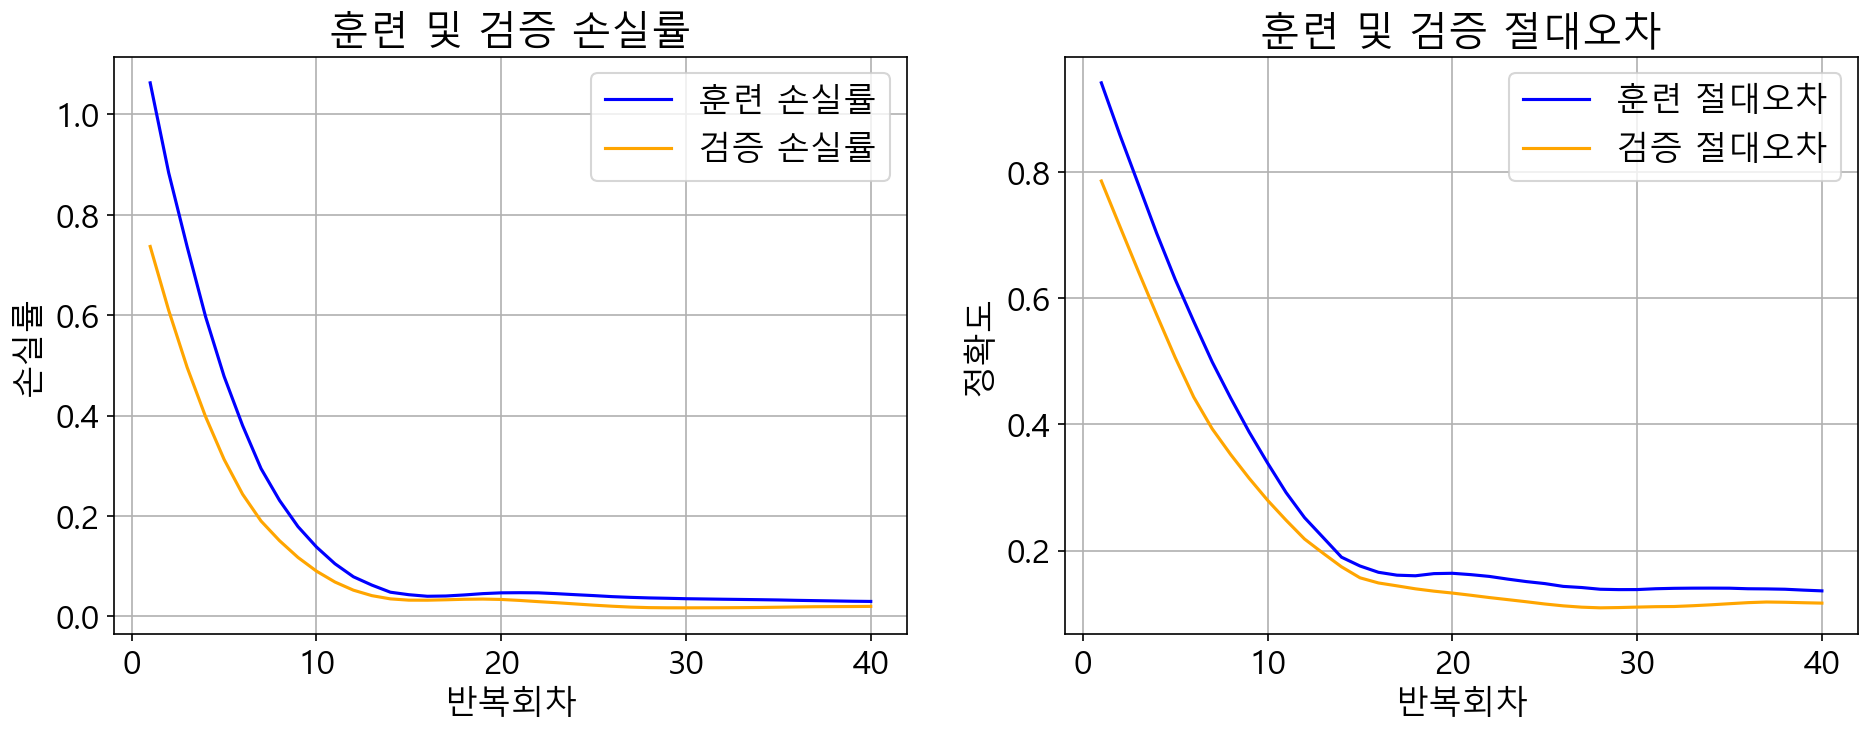

In [21]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ---------------------------------------
sb.lineplot(data=result_df, x=result_df.index, y='loss', color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(data=result_df, x=result_df.index, y='val_loss', color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()


# 2) 훈련 및 검증 절대오차 그리기
# ---------------------------------------
sb.lineplot(data=result_df, x=result_df.index, y='mae', color='blue', label='훈련 절대오차', ax=ax2)
sb.lineplot(data=result_df, x=result_df.index, y='val_mae', color='orange', label='검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()


In [22]:
evaluate1 = model.evaluate(x_train, y_train)
print('최종 훈련 손실률: %f, 최종 훈련 절대오차: %f' % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print('최종 검증 손실률: %f, 최종 검증 절대오차: %f' % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 8ms/step - loss: 0.0292 - mae: 0.1348
최종 훈련 손실률: 0.029160, 최종 훈련 절대오차: 0.134774
1/1 [==============================] - 0s 24ms/step - loss: 0.0198 - mae: 0.1166
최종 검증 손실률: 0.019806, 최종 검증 절대오차: 0.116623


## #08. 학습모델 적용

### 예측 결과 산정

In [23]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

1/1 [==============================] - 0s 24ms/step


### 결과 데이터 셋 구성

In [24]:
# 훈련데이터
train_df = DataFrame(x_train, columns=['길이','높이','두께'])
train_df['무게(관측치)'] = y_train.flatten()
train_df['무게(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.927534,-0.954292,-0.969558,-0.862814,-0.804097,-0.058717
1,-2.180225,-2.016507,-1.896175,-1.092422,-1.440206,0.347784
2,-0.659101,-0.779008,-0.696689,-0.761217,-0.645078,-0.116139
3,-0.368297,-0.396891,-0.327179,-0.563830,-0.431087,-0.132742
4,1.577847,1.731046,1.207709,2.083485,1.632671,0.450814


In [25]:
# 검증데이터
test_df = DataFrame(x_test, columns=['길이','높이','두께'])
test_df['무게(관측치)'] = y_test.flatten()
test_df['무게(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,길이,높이,두께,무게(관측치),무게(예측치),훈련오차
0,-0.659101,-0.614242,-0.696689,-0.732189,-0.635337,-0.096853
1,-0.770948,-0.761480,-0.611417,-0.746703,-0.640275,-0.106429
2,-0.580807,-0.670333,-0.634156,-0.688648,-0.599899,-0.088749
3,-0.043940,-0.204080,-0.099788,-0.383859,-0.255856,-0.128003
4,0.235678,-0.084887,0.013907,-0.180666,-0.045664,-0.135001


### 실제 결과값과 머신러닝에 의한 예측값 비교

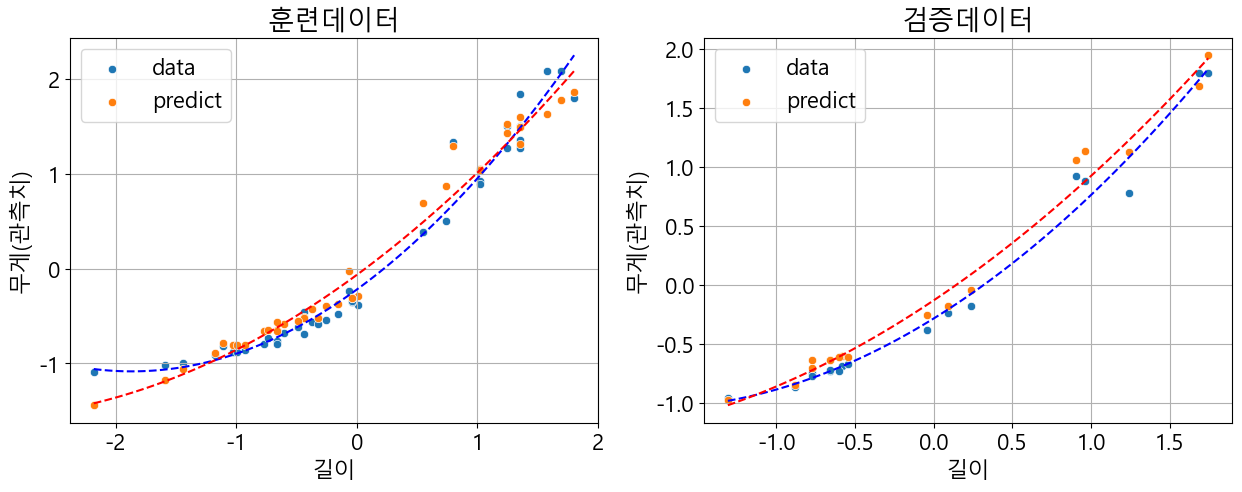

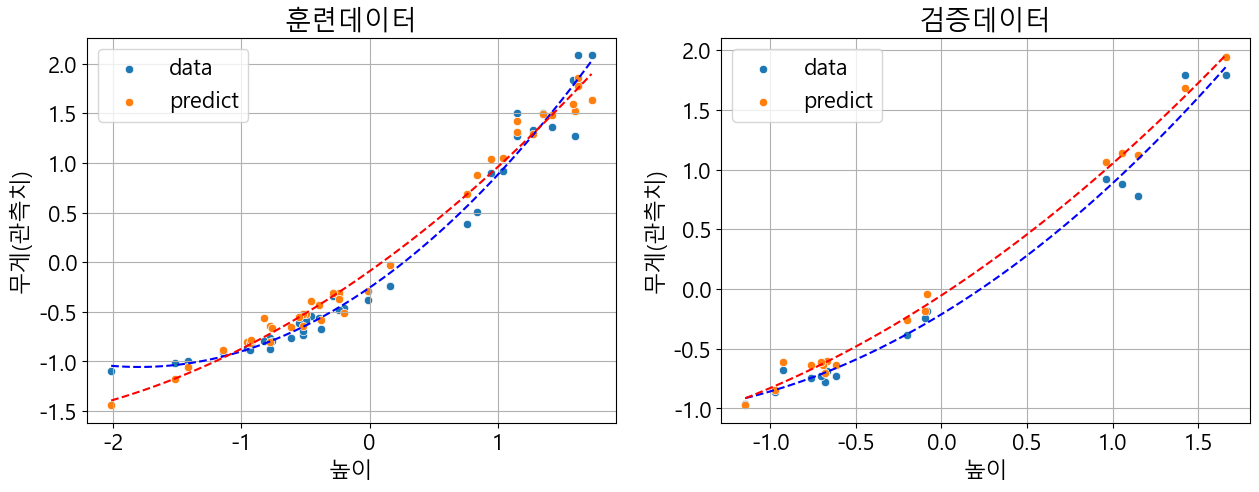

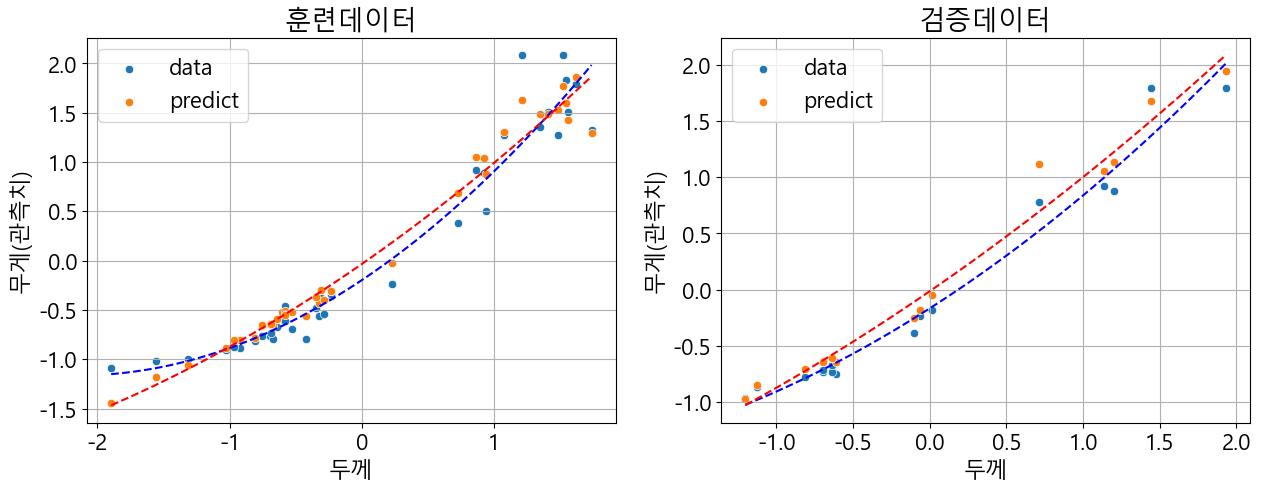

In [26]:
for key in ['길이','높이','두께']:
    helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
                    test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
                    figsize=(15,5))